# 데이터 불러오기

In [14]:
from matplotlib import pyplot as plt
from scipy import stats
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
%matplotlib inline

tf.random.set_seed(42) #재현을 위한 텐서플로우 seed 설정

data_train = pd.read_csv('./train.csv')
data_test = pd.read_csv('./test.csv')
print(data_train.shape)
data_train.head()

(2335, 34)


,id,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,...,sensor_24,sensor_25,sensor_26,sensor_27,sensor_28,sensor_29,sensor_30,sensor_31,sensor_32,target
0,1,-6.149463,-0.929714,9.058368,-7.017854,-2.958471,0.179233,-0.956591,-0.972401,5.956213,...,-7.026436,-6.006282,-6.005836,7.043084,21.884650,-3.064152,-5.247552,-6.026107,-11.990822,1
1,2,-2.238836,-1.003511,5.098079,-10.880357,-0.804562,-2.992123,26.972724,-8.900861,-5.968298,...,-1.996714,-7.933806,-3.136773,8.774211,10.944759,9.858186,-0.969241,-3.935553,-15.892421,1
2,3,19.087934,-2.092514,0.946750,-21.831788,9.119235,17.853587,-21.069954,-15.933212,-9.016039,...,-6.889685,54.052330,-6.109238,12.154595,6.095989,-40.195088,-3.958124,-8.079537,-5.160090,0
3,4,-2.211629,-1.930904,21.888406,-3.067560,-0.240634,2.985056,-29.073369,0.200774,-1.043742,...,-2.126170,-1.035526,2.178769,10.032723,-1.010897,-3.912848,-2.980338,-12.983597,-3.001077,1
4,5,3.953852,2.964892,-36.044802,0.899838,26.930210,11.004409,-21.962423,-11.950189,-20.933785,...,-2.051761,10.917567,1.905335,-13.004707,17.169552,2.105194,3.967986,11.861657,-27.088846,2


데이터를 보게되면 train data의 수가 2335로 매우 적으며, test data의 수가 train data의 약 5배 정도로 많은 것을 볼 수 있습니다.

따라서 저는 처음에 모델 튜닝보다는, train data의 수를 늘리는 방법에 대해 고민하는것이 훨씬 이득이라고 생각해서 train data를 증강해보기 위해서 다양하게 접근하였으나, 모두 실패하였습니다. (여기서 너무 많은 시간을 소모했습니다... sensor가 어떤 센서인지 도통 알수가 없네요)

현재 사용하고 있는 증강법은 데이터의 노이즈를 추가하는 방법 중 swap noise 하나밖에 없습니다. swap noise에 대해서는 아래 블로그에 잘 나와있습니다.

https://velog.io/@vvakki_/Tabular-Data%EC%A0%95%ED%98%95-%EB%8D%B0%EC%9D%B4%ED%84%B0%EC%97%90%EC%84%9C%EC%9D%98-Noise

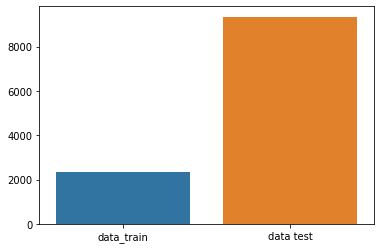

In [30]:
x = ["data_train", "data test"]
y = [data_train.shape[0], data_test.shape[0]]
ax = sns.barplot(x=x, y=y)

# 데이터 전처리

relu 함수를 activation에서 사용하고 있기 때문에 음수 값을 모두 양수로 만들어 dying relu를 만들지 않도록 했습니다.

또한 기존에 하던 것처럼 0~1값으로 Normalization을 진행해 입력의 범위를 맞춰주었으며, 값의 첨도가 높아 log변환을 시도해보았지만 성능이 더욱 좋지 않게 나와 그냥 나눠주었습니다.

https://yamalab.tistory.com/48 

위 블로그에서 발췌한 글입니다. 

input값에 음수가 포함이 된다면 기울기가 0이 되버리므로, 미분을 하면 backpropagation 과정 중간에 꺼져버리는 상황이 발생한다. Chain rule로 미분을 하기 때문에 음수가 한번 나오면 뒤에서도 다 꺼진다. 따라서 input 데이터에서 음수값이 포함되지 않도록 0~1사이의 값으로 정규화 시키는 과정을 거치는 것이 좋다.

In [16]:
train_X = data_train.drop(['target', 'id'], axis = 1)
train_X = (train_X+130)/260 
train_X = np.array(train_X)
train_X = np.array(train_X).reshape(-1, 8, 4, 1)

train_Y = data_train['target']
train_Y = np.array(train_Y)

X_test = data_test.drop('id', axis = 1)
X_test = (X_test+130)/260
X_test = np.array(X_test).reshape(-1, 8, 4, 1)

In [18]:
print("min :", train_X.min(), "\nmax :", train_X.max())

min : 0.008470580769230797 
max : 0.9890809815384616


In [19]:
train_X.shape

(2335, 8, 4, 1)

In [20]:
train_Y.shape

(2335,)

# 모델 생성하기


기세현님이 공유해주신 방식처럼 CNN으로 예측하는 방식이 가장 성능이 좋게 나와 저도 CNN을 기반으로 접근해보았습니다.

https://dacon.io/codeshare/4653

모델은 이전에 제가 사물 이미지 분류 경진대회에서 만들었던 ResNet 구조에, bottleneck 구조를 살려서 구현한 모델을 사용했습니다.

https://dacon.io/codeshare/4618

In [21]:
def identity_block(X, filters, kernel_size):
    X_shortcut = X
    
    X = tf.keras.layers.Conv2D(filters, (1,1), padding='SAME')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Activation('relu')(X)
    
    X = tf.keras.layers.Conv2D(filters, kernel_size, padding='SAME')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Activation('relu')(X)
    
    X = tf.keras.layers.Conv2D(filters*4, (1,1), padding='SAME')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    
    # Add
    X = tf.keras.layers.Add()([X, X_shortcut])
    X = tf.keras.layers.Activation('relu')(X)
    
    return X

In [22]:
def convolutional_block(X, filters, kernel_size):
    X_shortcut = X
    
    X = tf.keras.layers.Conv2D(filters, (1,1), padding='SAME')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Activation('relu')(X)
    
    X = tf.keras.layers.Conv2D(filters, kernel_size, padding='SAME')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Activation('relu')(X)
    
    X = tf.keras.layers.Conv2D(filters*4, (1,1), padding='SAME')(X)
    X = tf.keras.layers.BatchNormalization()(X)

    X_shortcut = tf.keras.layers.Conv2D(filters*4, (1,1), padding='SAME')(X_shortcut) #use 1x1 conv to make shape same
    X_shortcut = tf.keras.layers.BatchNormalization()(X_shortcut)
    
    # Add
    X = tf.keras.layers.Add()([X, X_shortcut])
    X = tf.keras.layers.Activation('relu')(X)
    
    return X

구글에 cnn rectangular images라고 검색하니 나온 이 article에서 음성 신호에서 감정을 인식하기 위해, 음성 신호를 image로 변환한 직사각형 input을 사용하고 있습니다. 여기서 구현한 모델을 보면 직사각형 input에는 직사각형 필터를 사용하고 있기 때문에 저도 **(3,2) (2,1) 처럼 직사각형 필터를 사용했습니다.** (성능이 향상되었습니다.)

https://www.researchgate.net/publication/320737885_Deep_features-based_speech_emotion_recognition_for_smart_affective_services

<img src = https://www.researchgate.net/profile/Jamil-Ahmad-13/publication/320737885/figure/fig2/AS:941749673414722@1601542027738/Proposed-CNN-architecture-with-rectangular-kernels.gif>

In [29]:
def CustomModel(input_shape = (8, 4, 1), classes = 4):
    X_input = tf.keras.layers.Input(input_shape)
    X = X_input
    
    X = convolutional_block(X, 128, (3,2)) #(3,3) 보다는 직사각형 이미지이기때문에 (3,2)처럼 직사각형 필터를 사용
    X = identity_block(X, 128, (3,2))
    X = identity_block(X, 128, (3,2))
    
    X = tf.keras.layers.AveragePooling2D(2,2)(X) #Max보다는 Average pool이 성능이 잘나옴

    X = convolutional_block(X, 256, (2,1)) #(2,1) 직사각형 필터를 사용
    X = identity_block(X, 256, (2,1))
    X = identity_block(X, 256, (2,1))
    
    X = tf.keras.layers.GlobalAveragePooling2D()(X) #Flatten 대신 사용
    
    X = tf.keras.layers.Dense(128, activation = "relu")(X)
    
    X = tf.keras.layers.Dropout(0.5)(X)
    
    X = tf.keras.layers.Dense(classes, activation = "softmax")(X)

    model = tf.keras.models.Model(inputs = X_input, outputs = X, name = "CustomModel")
    
    return model

# 모델 학습하기

우선 위에서 설명했던것처럼 train set이 너무 적고, test 셋이 train set에 비해 너무 많기 때문에 k-fold를 이용한 예측값을 사용하여 앙상블하게되면, 성능이 높게 올라가는 것을 알 수 있습니다.

따라서 train셋을 조금이라도 늘릴 방법에 대해서 중점적으로 접근해보았고, 많은 실패를 겪고 결국 swap noise 하나만 사용하게 되었습니다.

또한 Fold 횟수를 15번으로 설정한 것이 가장 점수가 높게 나와, 15번의 fold를 진행하도록 했습니다. (train data set이 너무 적어서 그런것 같습니다.)

In [24]:
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import shuffle

skf = StratifiedKFold(n_splits = 15, random_state = 42, shuffle = True) #총 15번의 fold 진행
n = 0 #x번째 fold인지 기록

cnn_pred = [] #모델의 예측값 모두 저장

for train_index, valid_index in skf.split(train_X, train_Y):
    n += 1
    X_train, X_valid = train_X[train_index], train_X[valid_index]
    y_train, y_valid = train_Y[train_index], train_Y[valid_index]

    ### Swap Noise ###
    X_train_mix = np.array(X_train)
    for x in range(X_train_mix.shape[0]):
        for i in range(5):
            y = np.random.randint(0, 8)
            z = np.random.randint(0, 4)
            
            while True:
                c = np.random.randint(0, X_train_mix.shape[0]-1)
                if ((x != c)and(y_train[x] == y_train[c])):
                    break
                    
            X_train_mix[x][y][z] = X_train[c][y][z]

    X_train = np.append(X_train, X_train_mix, axis = 0)
    y_train = np.append(y_train, y_train, axis = 0)
    
    ### Mix Data Again ####
    X_train, y_train = shuffle(X_train, y_train, random_state=42)
    
    y_train = tf.one_hot(y_train, 4)
    y_train = tf.reshape(y_train, [-1,4])
    y_train = np.array(y_train)
    
    y_valid = tf.one_hot(y_valid, 4)
    y_valid = tf.reshape(y_valid, [-1,4])
    y_valid = np.array(y_valid)
    
    ### Create Model ###
    model = CustomModel()
    
    ### Compile Model ###
    model.compile(optimizer='adam', # 무난한 adam 사용
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    ### Create callbacks ###
    filename = 'CNN-checkpoint.h5'
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filename,             # file명을 지정합니다
                                                    monitor='val_accuracy',   # val_accuracy 값이 개선되었을때 호출됩니다
                                                    verbose=0,            # 로그를 출력합니다 0일경우 출력 X
                                                    save_best_only=True,  # 가장 best 값만 저장합니다
                                                    mode='auto'           # auto는 알아서 best를 찾습니다. min/max (loss->min, accuracy->max)
                                                   )
    earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',  # 모니터 기준 설정 (val loss) 
                                  patience=12,         # 12 Epoch동안 개선되지 않는다면 종료
                                 )
    reduceLR = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_accuracy', # val_accuracy 값이 개선되었을때 호출됩니다
        factor=0.5, # learning rate이 0.5배 줄어듬
        patience=6, # 6 Epoch동안 개선되지 않는다면 호출
    )
    
    ### fit model ###
    data = model.fit(X_train, 
                     y_train, 
                     validation_data=(X_valid, y_valid), 
                     epochs=60, 
                     batch_size=32, # batch size가 32일때 가장 좋은 성능을 보임
                     callbacks=[reduceLR, earlystopping, checkpoint],
                     verbose=0 # 로그 출력을 없앰, 어짜피 아래 print에서 한번에 best_accuracy만 출력할것이기 때문이다.
                    )
    
    idx = data.history['val_accuracy'].index(max(data.history['val_accuracy']))
    
    print("fold %d / val_accuracy : %0.4f / val_loss : %0.4f" %(n,
                                                                data.history['val_accuracy'][idx], 
                                                                data.history['val_loss'][idx]))
    
    ### predict model ###
    model = tf.keras.models.load_model('./CNN-checkpoint.h5') # best accuracy를 기록한 모델을 불러옴
    pred_proba = model.predict(X_test) # 테스트 셋에 대한 예측 수행
    cnn_pred.append(pred_proba) # 예측값을 cnn_pred 리스트에 저장

C:\Users\LastDefiance\anaconda3\envs\ssu\lib\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


fold 1 / val_accuracy : 0.8910 / val_loss : 0.6203
fold 2 / val_accuracy : 0.8333 / val_loss : 0.4866
fold 3 / val_accuracy : 0.8782 / val_loss : 0.7207
fold 4 / val_accuracy : 0.8974 / val_loss : 0.6771
fold 5 / val_accuracy : 0.9038 / val_loss : 0.4689
fold 6 / val_accuracy : 0.8590 / val_loss : 0.5532
fold 7 / val_accuracy : 0.8654 / val_loss : 0.5898
fold 8 / val_accuracy : 0.8974 / val_loss : 0.8402
fold 9 / val_accuracy : 0.8782 / val_loss : 0.6116
fold 10 / val_accuracy : 0.8782 / val_loss : 0.4823
fold 11 / val_accuracy : 0.8581 / val_loss : 0.9745
fold 12 / val_accuracy : 0.8258 / val_loss : 0.8205
fold 13 / val_accuracy : 0.8968 / val_loss : 0.7462
fold 14 / val_accuracy : 0.8968 / val_loss : 0.8990
fold 15 / val_accuracy : 0.8903 / val_loss : 0.7271


# 제출하기

이전에 계산했던 model.predict 값이 저장된 cnn_pred 리스트에 있는 값을 모두 더한 후, argmax를 이용하여 예측값을 출력합니다.

In [25]:
pred_proba = cnn_pred[0]
pred_proba = np.array(pred_proba)
print(pred_proba[0])

for x in range(1, 15):
    pred_proba += cnn_pred[x]
    print(cnn_pred[x][0])

pred_class = []

for i in pred_proba:
    pred = np.argmax(i)
    pred_class.append(pred)

[9.9998200e-01 5.9752169e-06 8.7663730e-06 3.2298253e-06]
[0.97598696 0.00577842 0.01719919 0.00103535]
[0.9768521  0.00525254 0.01474087 0.00315449]
[1.0000000e+00 1.9110527e-10 1.9541596e-11 1.0021416e-09]
[9.9918634e-01 8.4004132e-06 7.8036642e-04 2.4830451e-05]
[9.99999285e-01 1.43209915e-08 5.48386652e-07 1.61913192e-07]
[9.9996364e-01 5.4064834e-08 3.4444300e-05 1.8961626e-06]
[9.9999964e-01 2.1311675e-07 7.5045534e-08 2.2922140e-09]
[9.9991524e-01 6.3283274e-05 2.1003960e-05 4.4668801e-07]
[9.8618466e-01 3.4116080e-04 1.1958394e-02 1.5157476e-03]
[9.9999690e-01 5.5355116e-08 2.6908785e-06 4.6398733e-07]
[9.9849272e-01 1.3228181e-04 4.9938250e-04 8.7562570e-04]
[9.9998605e-01 6.1045571e-06 7.6500637e-06 2.0100140e-07]
[1.0000000e+00 4.6204334e-12 2.1243608e-12 6.1020972e-10]
[9.9999750e-01 7.5454857e-08 2.0532323e-07 2.1380079e-06]


In [26]:
import pandas as pd

sample_submission = pd.read_csv("./sample_submission.csv")

sample_submission.target = pred_class
sample_submission.to_csv("submit_25.csv",index=False)

In [27]:
sample_submission.head()

,id,target
0,1,0
1,2,0
2,3,1
3,4,3
4,5,2
